# Exercise 2 -- Training and evaluating the Elman recurrent neural network model

We now assemble and train an Elman recurrent neural network (RNN). Given a series of inputs $\mathbf{x} = (x_1, x_2, \ldots, x_{t-1}, x_{t} \ldots, x_{l_{\mathrm{seq}}})$, the Elman RNN can be recursively defined via the relations
$$
f(h_{t-1}, x_t) = \sigma(W_h h_{t-1} + W_{x} x_t + b_h)
$$
and
$$
g(h_t) = \sigma(W_y h_t + b_y),
$$
where $h_{t}$ is the so-called *hidden state* at time $t$. Furthermore $W_h$, $W_{x}$, $W_{y}$, $b_h$ and $b_y$ are the learnable weights and biases of linear neural networks used in the hidden state propagation (function $f$) and prediction of output at time $t$ (function $g$). $\sigma$ is a non-linearity, commonly a $\tanh$ or $RELU$ function. The image below visualizes how the the output of the RNN at time $t$ is given as a function of the input $x_t$ and the hidden state $h_t$ at time $t$. The hidden state encodes thereby the *history* or sequence of previous inputs.

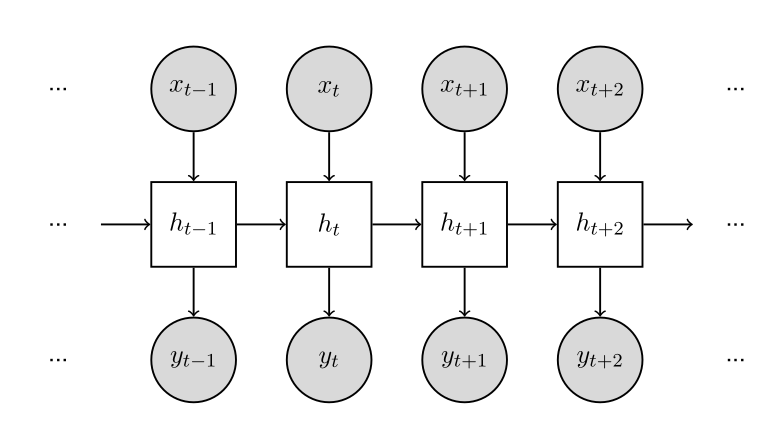

In [1]:
from PIL import Image
pil_im = Image.open('RNN_scheme.png')
display(pil_im)

## Implementing the Elman RNN

We have implemented the network described above using pytorch. We thereby leverage the implementations of the RNN layer in pytorch, `torch.nn.RNN()` (https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) and the embedding layer `torch.nn.Embedding()` (https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html). We implement a custom model class `MyNetwork()` and the details of the implementation can be seen in the code snippet below.


In [2]:
from IPython.display import Code
Code(filename='mymodel.py', language='python')

import torch
import torch.nn as nn
import torch.nn.functional as F


# Define the Elman network class
class MyNetwork(nn.Module):
    def __init__(self, embedding_dim=100, hidden_size=100, nlayers=1, vocab_size=10000, rnn_type='RNN'):
        super(MyNetwork, self).__init__()
        
        # Define the embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Define the RNN layer
        if rnn_type == 'RNN':
            # standard Elman RNN
            self.rnn = nn.RNN(embedding_dim, hidden_size, num_layers=nlayers)
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(embedding_dim, hidden_size, num_layers=nlayers)
        else:
            raise NotImplementedError()
        
        # Define the output layer
        self.output_layer = nn.Linear(hidden_size, vocab_size)

        self.hidden_size = hidden_size
        self.nlayers = nlayers
        self.vocab_size = vocab_size
        self.rnn_type = rnn_type
        self.epoch = 0
    
    
    def forward(self, input, hidden=None):
        # Apply word embedding to input
        embedded = self.embedding(input)

        # Forward pass through the RNN layer
        if hidden is not None:
            output, hidden = self.rnn(embedded, hidden)
        else:
            output, hidden = self.rnn(embedded)

        # Apply the output layer and return the output
        output = self.output_layer(output).view(-1, self.vocab_size)
        
        return output, hidden
    
    
    def init_hidden(self, batch_size, method='zeros'):
        weight = next(self.parameters())
        if self.rnn_type == 'LSTM':
            if method == 'zeros':
                return (weight.new_zeros(self.nlayers, batch_size, self.hidden_size),
                        weight.new_zeros(self.nlayers, batch_size, self.hidden_size))
            elif method == 'uniform':
                return (weight.uniform(self.nlayers, batch_size, self.hidden_size),
                        weight.uniform(self.nlayers, batch_size, self.hidden_size))
            else:
                raise NotImplementedError()
        else:
            if method == 'zeros':
                return weight.new_zeros(self.nlayers, batch_size, self.hidden_size)
            elif method == 'uniform':
                return weight.uniform(self.nlayers, batch_size, self.hidden_size)
            else:
                raise NotImplementedError()

We initialize the network using the code snippet below and use our gpu.

In [3]:
import torch
from mymodel import MyNetwork
device = torch.device("cuda")
model = MyNetwork().to(device)

## Implementing a data loading routine

Before we can train the network, we need to come up with a dataloading routine. The goal is to split the whole sequence of integers representing the entire text string of the dataset into $l_{\mathrm{seq}}$ sequences, of which $b$ are loaded at each training iteration. We follow here the implementation of this strategy as in the `main.py` script of the pytorch word language model example found at

https://github.com/pytorch/examples/tree/main/word_language_model

rather than a straightforward implementation of the ideas laid out in the instructions, since the strategy used in the pytorhc example leads to lower resource consumption. We start by loading the text using the routine we have developed in exercise 1 and choosing some batch size $b$ and sequence length $l_{\mathrm{seq}}$.

In [4]:
from corpus import Corpus
corpus = Corpus('ptb_data')

batch_size = 100
l_seq = 20

Next we divide each of the data sets into $b$ sequences using the `batchify()` function of the pytorch language model example.

In [5]:
def batchify(data, bsz):
    """ Credit for this function:
        https://github.com/pytorch/examples/blob/main/word_language_model/main.py
    """
    # Work out how cleanly we can divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

train_data = batchify(corpus.train, batch_size)
val_data = batchify(corpus.valid, batch_size)
test_data = batchify(corpus.test, batch_size)

Let's check the shape of the tensor containing the training data and also compare the first few rows and coulmns to the training data in the original `corpus.train`.

In [6]:
print(train_data.shape)
print(train_data[:10,:3])

# This is the first colum of train_data[:10,:3]
print(corpus.train[:10])
# This is the second colum of train_data[:10,:3]
print(corpus.train[train_data.shape[0]:train_data.shape[0]+10])
# This is the third colum of train_data[:10,:3]
print(corpus.train[2*train_data.shape[0]:2*train_data.shape[0]+10])

torch.Size([9295, 100])
tensor([[   0,  467,   48],
        [   1,  160,  166],
        [   2, 1112, 3174],
        [   3,  566, 3161],
        [   4,  749,  498],
        [   5,   93, 2970],
        [   6, 1123,  181],
        [   7,   24, 2587],
        [   8, 2006,   34],
        [   9, 1752,  250]], device='cuda:0')
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([ 467,  160, 1112,  566,  749,   93, 1123,   24, 2006, 1752])
tensor([  48,  166, 3174, 3161,  498, 2970,  181, 2587,   34,  250])


We see that we have split the data into $b$ sequences and stored them in a tensor. In a next step we will need to further split these sequences into sequences of size $l_{\mathrm{seq}}$. To that end we follow the same strategy as in the pytorch example and define another function, which will return $b$ sequences of length $l_{\mathrm{seq}}$ starting with a specified index $i$. The function returns furthermore the input data to the RNN as well as the correct labels (targets).

In [7]:
def get_batch(source, i):
    seq_len = min(l_seq, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].view(-1)
    return data, target

We check the output of this function and note that the targets are given as a flattened array, which is the reason, why we return a view `.view(-1, self.vocab_size)` of the output in our model in `mymodel.py`.

In [8]:
data, targets = get_batch(train_data, 0)
print(data.shape)
print(targets.shape)
print(data[:10,:3])
print(targets[:10])

torch.Size([20, 100])
torch.Size([2000])
tensor([[   0,  467,   48],
        [   1,  160,  166],
        [   2, 1112, 3174],
        [   3,  566, 3161],
        [   4,  749,  498],
        [   5,   93, 2970],
        [   6, 1123,  181],
        [   7,   24, 2587],
        [   8, 2006,   34],
        [   9, 1752,  250]], device='cuda:0')
tensor([   1,  160,  166,  160,   34,  152, 2679, 5910,   26,  114],
       device='cuda:0')


With this data loading strategy implemented, the core of the training loop will be:
```
for batch, i in enumerate(range(0, train_data.size(0) - 1, l_seq)):
    data, targets = get_batch(train_data, i)
    ...
```
i.e., in each iteration, we will load $b$ sequences of length $l_{\mathrm{seq}}$, which are mutually non-overlapping. This strategy is thus equivalent to a naive implementation of the ideas given in the instructions.

## Training the Elman RNN

We are now ready to train the network. We use the pytorch function `CrossEntropyLoss()` as a loss function and the standard stochastic gradient descent optimizer `SGD()`.

In [9]:
import torch.optim as optim
lr = 3
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay = 0, momentum = 0.0)

Next we write out the training loop, which performs one epoch of training. Based on our observations before, it is pretty straightforward to write up.

In [10]:
import time
import math
def train():
    # Turn on training mode which enables dropout.
    model.train()
    
    for batch, i in enumerate(range(0, train_data.size(0) - 1, l_seq)):
        data, targets = get_batch(train_data, i)
        
        optimizer.zero_grad()
        
        output, hidden = model(data)
        loss = loss_fn(output, targets)
        loss.backward()

        optimizer.step()
    
    model.epoch += 1

We also need a function to evaluate the performance of our model. To that end, we reuse the function `evaluate()` from the pytorch language model example in the code below:

In [11]:
def evaluate(data_source):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    total_loss = 0.
    ntokens = len(corpus.dictionary)
    
    hidden = model.init_hidden(batch_size)
    
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, l_seq):
            data, targets = get_batch(data_source, i)
            output, hidden = model(data, hidden)
            #hidden = repackage_hidden(hidden)
            total_loss += len(data) * loss_fn(output, targets).item()
    return total_loss / (len(data_source) - 1)

Furthermore we also create a convenience function `train_nepochs()`, which performs the training of the RNN for a certain number of epochs.

In [12]:
def train_nepochs(nepochs, best_val_loss, fname):
    
    train_loss = []
    val_loss = []
    
    for epoch in range(1, nepochs+1):
        
        epoch_start_time = time.time()
        train()
        train_loss.append(evaluate(train_data))
        val_loss.append(evaluate(val_data))
        
        print('|          {:3d} |   {:5.2f}s |   {:5.2f} |   {:5.2f} |    {:8.2f} |    {:8.2f} |'\
              .format(model.epoch, model.time,
                      train_loss[-1], val_loss[-1], math.exp(train_loss[-1]),
                      math.exp(val_loss[-1])))
        print('-' * 75)
    
        # Save the model if the validation loss is the best we've seen so far.
        if not best_val_loss or val_loss[-1] < best_val_loss:
            with open(fname, 'wb') as f:
                torch.save(model, f)
            best_val_loss = val_loss[-1]
    
    return train_loss, val_loss, best_val_loss

And we also define a helper function for loading a saved network:

In [24]:
def load_model(fname):
    model = torch.load(fname)
    train_loss = [evaluate(train_data), ]
    val_loss = [evaluate(val_data), ]
    best_val_loss = [val_loss, ]
    
    print_log_head()
    print('|          {:3d} |   {:5.2f}s |   {:5.2f} |   {:5.2f} |    {:8.2f} |    {:8.2f} |'\
          .format(model.epoch, .0,
                  train_loss[-1], val_loss[-1], math.exp(train_loss[-1]),
                  math.exp(val_loss[-1])))
    print('-' * 75)
    
    return model, train_loss, val_loss, best_val_loss

Finally we can execute the whole training scheme and loop over epochs.

In [25]:
# Loop over epochs.
best_val_loss = None
nepochs = 50
fname = 'exercise2.torch'

from fcns import print_log_head
from os.path import exists

if not exists(fname):
    print_log_head()
    train_loss, val_loss, best_val_loss = train_nepochs(nepochs, best_val_loss, fname)
else:
    model, train_loss, val_loss, best_val_loss = load_model(fname)

---------------------------------------------------------------------------
|              |          |       loss        |        perplexity         |
| end of epoch |   time   |-------------------|---------------------------|
|              |          |  train  |  valid  |    train    |    valid    |
---------------------------------------------------------------------------
---------------------------------------------------------------------------
|           33 |    0.00s |    4.99 |    5.44 |      147.66 |      229.87 |
---------------------------------------------------------------------------


ValueError: too many values to unpack (expected 3)

We plot now the loss of the model on the training data and the validation data in the figure below. Note how the training loss improves much more during training than the validation loss, indicating a certain amount of overfitting to the training data. Despite of this the validation loss still continued to improve as a function of elapsed epoch until about epoch 33 for which we observed the smallest loss on the validation data.

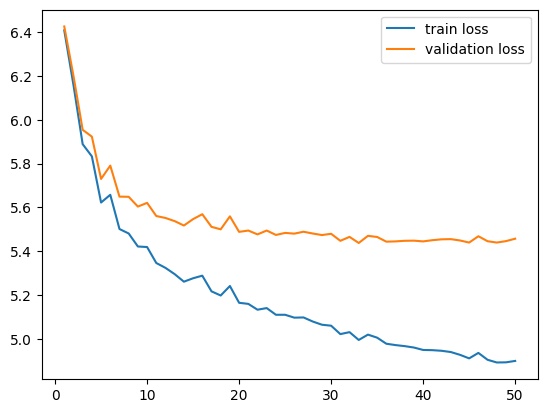

In [16]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()

ax.plot(np.arange(1, len(train_loss)+1), train_loss, label='train loss')
ax.plot(np.arange(1, len(val_loss)+1), val_loss, label='validation loss')
ax.legend()

## Evaluating the best obtained model

We will now evaluate the best model we have obtained. This is easily achieved by just loading the saved model from disk and running it on the test data.

In [17]:
model = torch.load('exercise2.torch')
test_loss = evaluate(test_data)
print('The perpelexity in the test set is {:8.2f}'.format(math.exp(test_loss)))

The perpelexity in the test set is   216.53


We see that this preplexity is much larger than the perplexity obtained by state-of-the-art language models (c.f. https://paperswithcode.com/sota/language-modelling-on-penn-treebank-word), but that is not so surprising as we use a very simple model here with no optimizations. We will see in exercise 3 how we can improve the model performance.

## Generating sample phrases

We now use our Elman RNN to generate some sample phrases. We implement here two of the methods described in the instructions, namely the *greedy* and *sampling* methods. Using the *greedy* method, the output is taken to be the output with the largest likelihood over all classes. In the *sampling* method on the other hand, the output is determined with a certain probability, taken to be the probability for the word predicted by the RNN. The code for these samling methods is printed below:

In [18]:
import numpy as np
import torch.nn.functional as F
def generate_sample_phrase(seed_phrase, ngen, method='sample'):
    model.eval()
    hidden = model.init_hidden(1)
    
    for word in seed_phrase.split():
        inp = torch.tensor(corpus.dictionary.word2idx[word]).to(device).view(-1,1)
        output, hidden = model(inp, hidden)
    
    out_phrase = seed_phrase
    for i in range(ngen):
        P = F.softmax(output, dim=1).cpu().detach().numpy().reshape(-1)
                
        if method == 'sample':
            new_idx = np.random.choice(np.arange(1, 10001), 1, p=P)[0]
        elif method == 'greedy':
            new_idx = np.argmax(P)
        else:
            raise NotImplementedError('')
        
        new_word = corpus.dictionary.idx2word[new_idx]
        
        out_phrase += f' {new_word}'
        
        inp = torch.tensor(new_idx).to(device).view(-1,1)
        output, hidden = model(inp, hidden)
    
    return out_phrase

We generate now two phrases using the *smapling* method. We see that the two phrases differ as we expect from a probabilistic method. Thehis indicates that we need to refine and improve our model more.

In [19]:
print(generate_sample_phrase('i have to', 10, method='sample'))
print(generate_sample_phrase('i have to', 10, method='sample'))

print(generate_sample_phrase('the house is', 10, method='sample'))
print(generate_sample_phrase('the house is', 10, method='sample'))

i have to processes stockholders more ago pierre specifications early pierre matters capture
i have to board n.v. items its england saw risk risk n.v. its
the house is painewebber financial underscore N gone stable huge N years pierre
the house is standard N make totaled during audit dumped n.v. smokers mayoral


Next we also use the *greedy* method to generate example phrases. Two phrases for the same input sequence do not differ, since the network predicts the same maximum probabilities in the two runs as one would expect. Furthermore one can see that there seems to be a tendency for the *greedy* method to get stuck in a loop of repeating the same words, which are ubiquitous in the data set and in the english language. Furthermore the sequences `<unk>` and `<eos>` probably appear semi-randomly in the data and have rather high probabilities to appear anywhere.

In [20]:
print(generate_sample_phrase('i have to', 10, method='greedy'))
print(generate_sample_phrase('i have to', 10, method='greedy'))

print(generate_sample_phrase('the house is', 10, method='greedy'))
print(generate_sample_phrase('the house is', 10, method='greedy'))

i have to the <unk> of the <unk> of the <unk> of the
i have to the <unk> of the <unk> of the <unk> of the
the house is <unk> to the <unk> of the <unk> of the <unk>
the house is <unk> to the <unk> of the <unk> of the <unk>
